# Capstone Project - Predictive Maintenance of Cloud Datacenter

Predictive maintenance is a proactive approach to managing and maintaining equipment in data centers, leveraging data analysis to predict and prevent equipment failures. This strategy is essential for ensuring operational efficiency, reducing downtime, and extending the lifespan of critical infrastructure.

In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from math import ceil
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import LabelEncoder


# Data Description

There are 5 CSV files consisting of:
**Telemetry** (telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration.

**Error** (errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures.

**Maintenance** (maint.csv): If a component of a machine is replaced, that is captured as a record in this table.
    
**Failures** (failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. 

**Machines** (machines.csv): Model type & age of the Machines.

In [3]:
# Load each CSV file into a DataFrame
errors = pd.read_csv('PdM_errors.csv')
machines = pd.read_csv('PdM_machines.csv')
failures = pd.read_csv('PdM_failures.csv')
maintenance = pd.read_csv('PdM_maint.csv')
telemetry = pd.read_csv('PdM_telemetry.csv')


In [4]:
# Display the first few rows of each DataFrame
print("Machines DataFrame:")
print(machines.head())

print("Errors DataFrame:")
print(errors.head())

print("Failures DataFrame:")
print(failures.head())

print("Maintenance DataFrame:")
print(maintenance.head())

print("Telemetry DataFrame:")
print(telemetry.head())


Machines DataFrame:
   machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model3    2
Errors DataFrame:
              datetime  machineID errorID
0  2015-01-03 07:00:00          1  error1
1  2015-01-03 20:00:00          1  error3
2  2015-01-04 06:00:00          1  error5
3  2015-01-10 15:00:00          1  error4
4  2015-01-22 10:00:00          1  error4
Failures DataFrame:
              datetime  machineID failure
0  2015-01-05 06:00:00          1   comp4
1  2015-03-06 06:00:00          1   comp1
2  2015-04-20 06:00:00          1   comp2
3  2015-06-19 06:00:00          1   comp4
4  2015-09-02 06:00:00          1   comp4
Maintenance DataFrame:
              datetime  machineID   comp
0  2014-06-01 06:00:00          1  comp2
1  2014-07-16 06:00:00          1  comp4
2  2014-07-31 06:00:00          1  comp3
3  2014-12-13 06:00:00          1  comp1
4  2015-01-05 06:00:00          1  comp4
Telemetry Dat

We will start by merging files so we have a single dataframe. First we will mege failures with telemetry dataset.

In [5]:
# Merge failures with telemetry
failures = failures.sort_values(by='datetime')
failures.reset_index(inplace=True, drop=True)
failures.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,56,comp3
1,2015-01-02 03:00:00,99,comp3
2,2015-01-02 03:00:00,83,comp4
3,2015-01-02 03:00:00,59,comp1
4,2015-01-02 03:00:00,16,comp1


In [6]:
failures.isnull().sum() #Check for null values in a dataset

datetime     0
machineID    0
failure      0
dtype: int64

In [7]:
#Merge telemetry with failure dataset, fill null values with No failure
telemetry_with_failure_df = telemetry.merge(failures, on=['datetime', 'machineID'], how='left')
telemetry_with_failure_df.fillna('No Failure', inplace=True)

Checking first few rows after merging 2 csv's

In [8]:
telemetry_with_failure_df.head() #Check for null values in merged dataset

,datetime,machineID,volt,rotate,pressure,vibration,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,No Failure
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,No Failure
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,No Failure
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,No Failure
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,No Failure


Getting info on the dataset ater merging these 2 files

In [9]:
telemetry_with_failure_df.info() #Gt info of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876142 entries, 0 to 876141
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876142 non-null  object 
 1   machineID  876142 non-null  int64  
 2   volt       876142 non-null  float64
 3   rotate     876142 non-null  float64
 4   pressure   876142 non-null  float64
 5   vibration  876142 non-null  float64
 6   failure    876142 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 46.8+ MB


In [10]:
telemetry_with_failure_df['failure'].value_counts() 

failure
No Failure    875381
comp2            259
comp1            192
comp4            179
comp3            131
Name: count, dtype: int64

Above shows the Dataset is highly imbalanced. 

Merging Machines with above merged dataframe.

In [11]:
#Merge MAchines with above dataset.
telemetry_with_failure_df = machines.merge(right=telemetry_with_failure_df, on=['machineID'], how='left')
telemetry_with_failure_df.head()


,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure


In [12]:
telemetry_with_failure_df['model'].value_counts() #Get count of machines by model

model
model3    306644
model4    280363
model2    148945
model1    140190
Name: count, dtype: int64

In [13]:
telemetry_with_failure_df.info() #Get info on newly merged dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876142 entries, 0 to 876141
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   machineID  876142 non-null  int64  
 1   model      876142 non-null  object 
 2   age        876142 non-null  int64  
 3   datetime   876142 non-null  object 
 4   volt       876142 non-null  float64
 5   rotate     876142 non-null  float64
 6   pressure   876142 non-null  float64
 7   vibration  876142 non-null  float64
 8   failure    876142 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 60.2+ MB


Assigning Merged dataframes to df variable for simplicity

In [14]:
df = telemetry_with_failure_df

We will now examine the dataframe; EDA for numerical and Categorical features.

In [15]:
df.head() #Get top 5 rows

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure


In [16]:
df.info() #Get pverall info on this dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876142 entries, 0 to 876141
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   machineID  876142 non-null  int64  
 1   model      876142 non-null  object 
 2   age        876142 non-null  int64  
 3   datetime   876142 non-null  object 
 4   volt       876142 non-null  float64
 5   rotate     876142 non-null  float64
 6   pressure   876142 non-null  float64
 7   vibration  876142 non-null  float64
 8   failure    876142 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 60.2+ MB


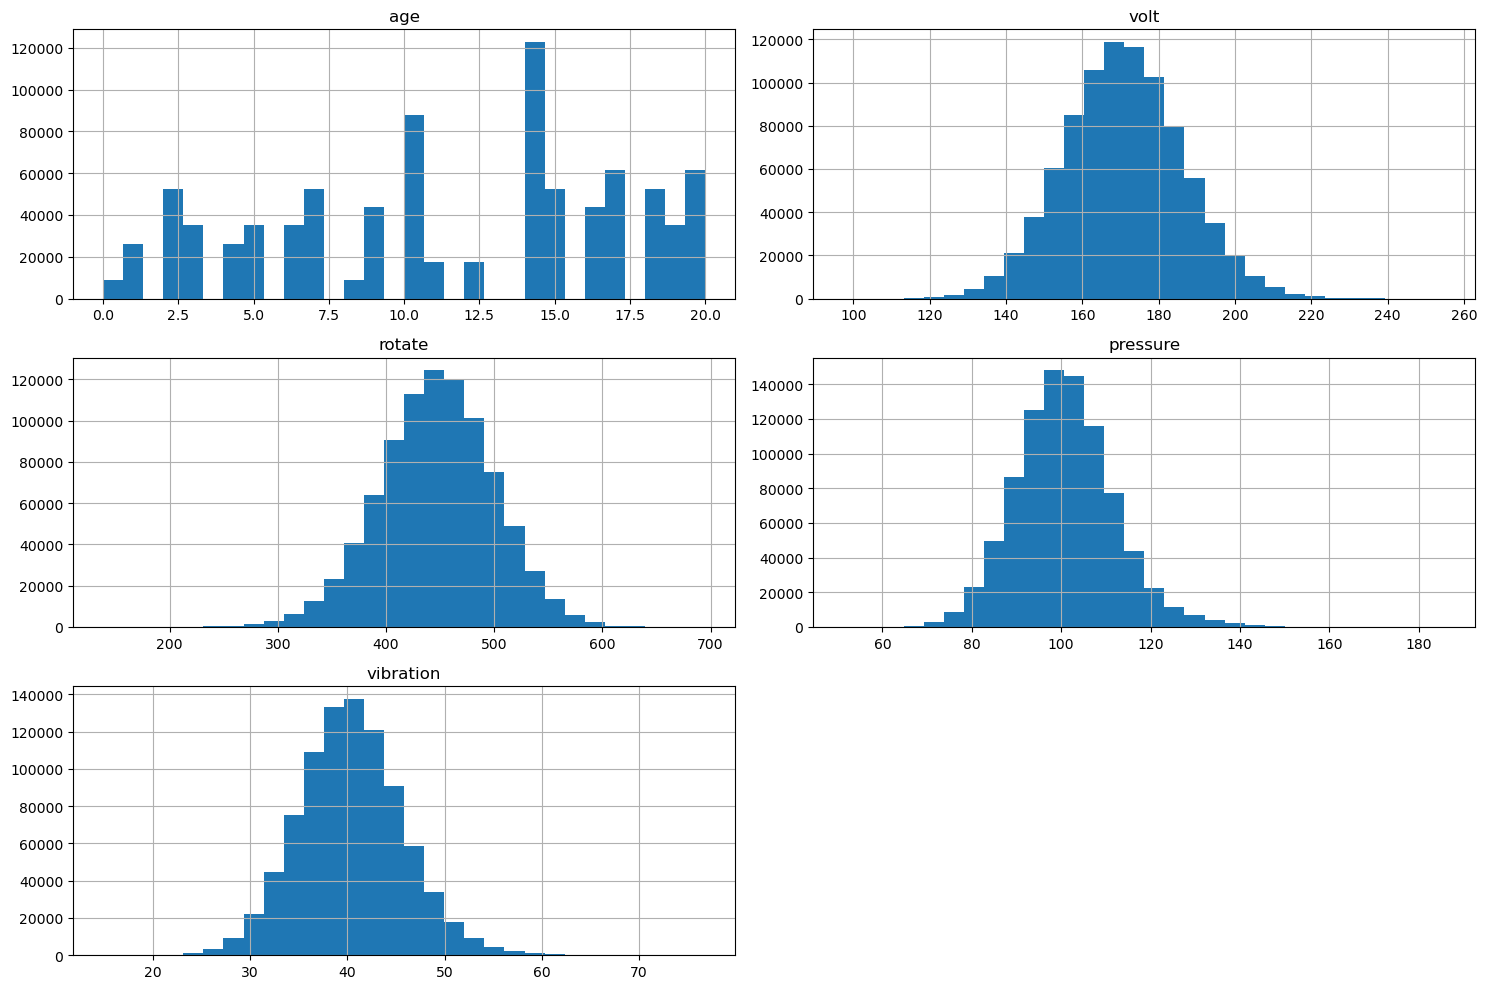

In [17]:
# Histograms for numerical features
df[['age', 'volt', 'rotate', 'pressure', 'vibration']].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

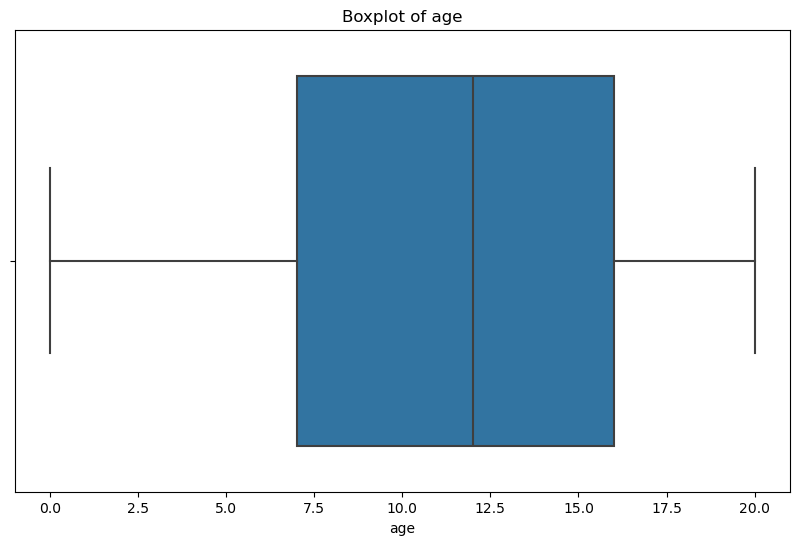

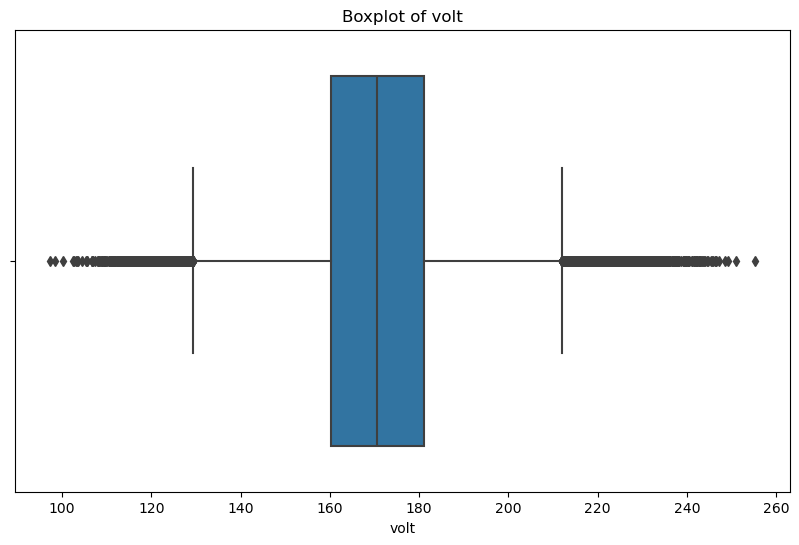

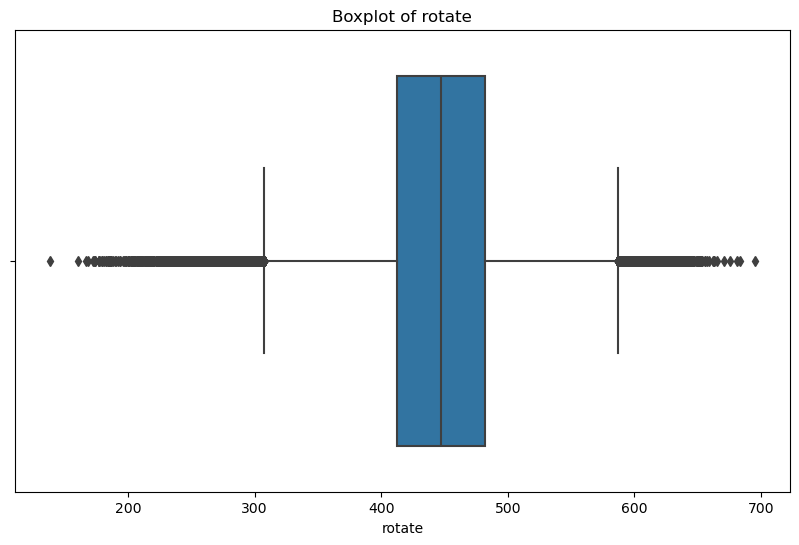

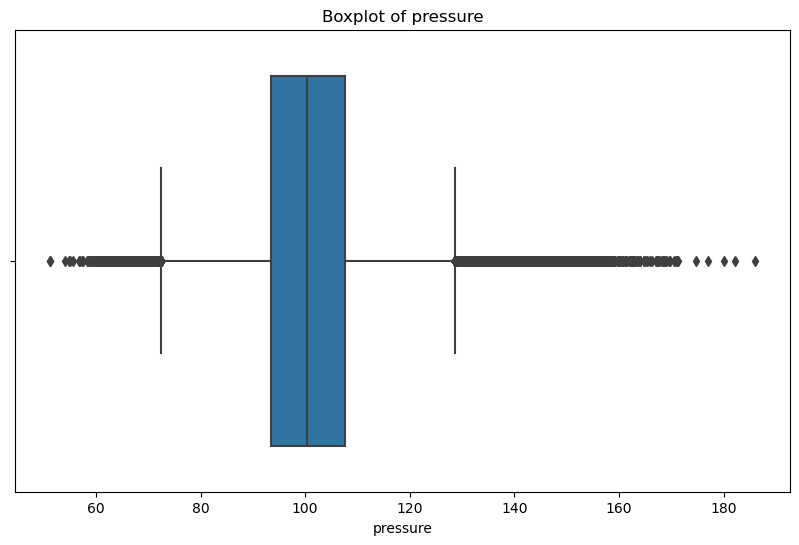

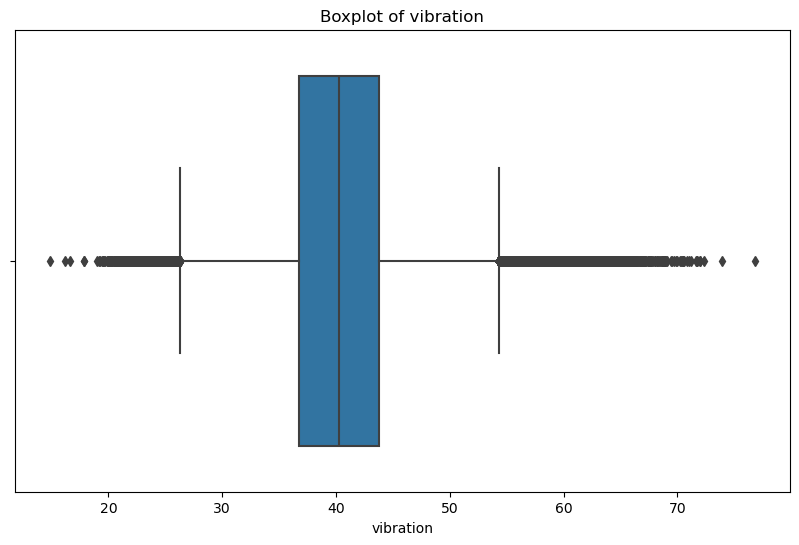

In [18]:
# Box plots to identify outliers
numerical_cols = ['age', 'volt', 'rotate', 'pressure', 'vibration']
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

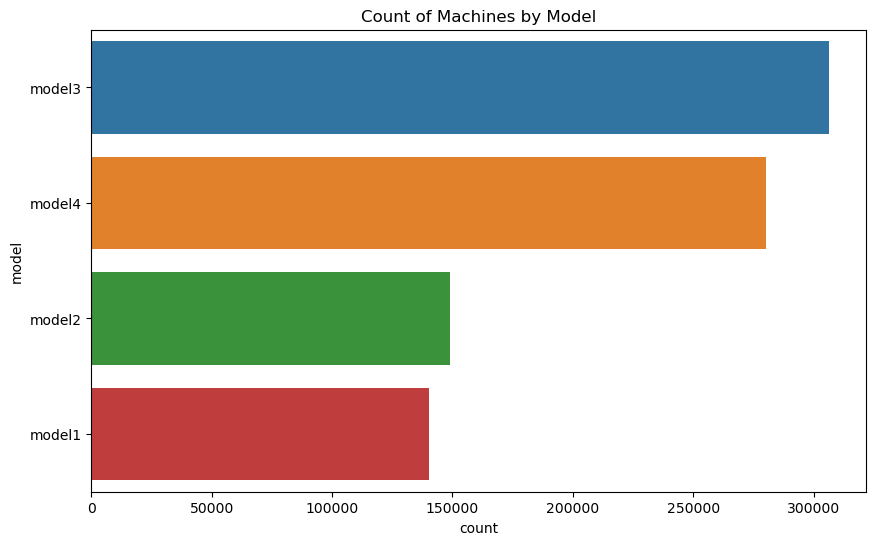

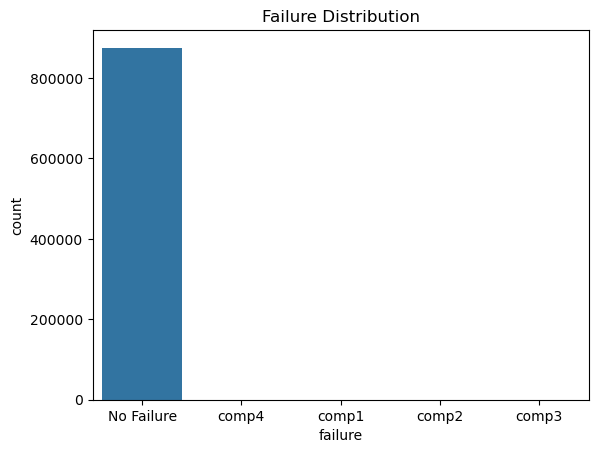

In [19]:
# Count plots for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(y='model', data=df, order=df['model'].value_counts().index)
plt.title('Count of Machines by Model')
plt.show()

sns.countplot(x='failure', data=df)
plt.title('Failure Distribution')
plt.show()

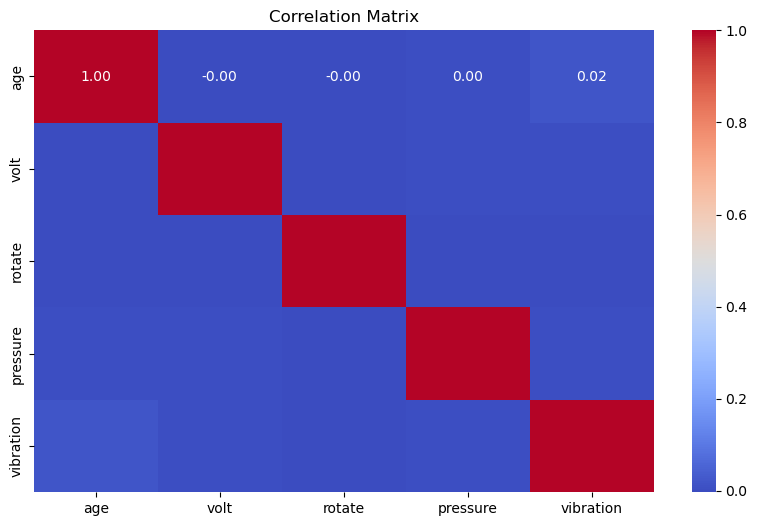

In [20]:
# Correlation Matrix
correlation = df[numerical_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [21]:
df['datetime'] = pd.to_datetime(df['datetime']) #Converting to Pandas datatime

# Observation(s):
This dataframe is highly imbalanced. Below is the breakdown of failures in the dataset**failure**

No Failure    875381
comp2            259
comp1            192
comp4            179
comp3          

The model breakdown of machines are below
**model**
model3    306644
model4    280363
model2    148945
model1    140190  131



In [23]:
import numpy as np
np.random.seed(42)

In [24]:
# Encode the target variable
label_encoder = LabelEncoder()
df['failure'] = label_encoder.fit_transform(df['failure'])  # 'Yes' becomes 1, 'No' becomes 0

# Define features and target
X = df[['age', 'volt', 'rotate', 'pressure', 'vibration']]
y = df['failure']  # Encoded target

Split the dataset with test and train sets

In [25]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Initialize Logistic Regression with class weights
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42)

In [27]:
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test)

In [28]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Confusion Matrix:
[[60324 44738 19983 25279 24753]
 [    3    21     7     1     6]
 [    1    18    16    11     6]
 [    2     0     2    21     1]
 [    3     2     4     2    25]]

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.34      0.51    175077
       comp1       0.00      0.55      0.00        38
       comp2       0.00      0.31      0.00        52
       comp3       0.00      0.81      0.00        26
       comp4       0.00      0.69      0.00        36

    accuracy                           0.34    175229
   macro avg       0.20      0.54      0.10    175229
weighted avg       1.00      0.34      0.51    175229



The classification report provides a comprehensive summary of the model's performance across different classes. Let's break down the output step-by-step:

### Key Metrics Explained

1. **Precision**: 
   - The ratio of correctly predicted positive observations to the total predicted positives.
   - For example, for `comp1`, the precision is `0.00`, meaning that when the model predicted `comp1`, it was never correct (all predictions were false positives).

2. **Recall (Sensitivity)**:
   - The ratio of correctly predicted positive observations to all actual positives.
   - For `comp1`, the recall is `0.55`, indicating that 55% of actual `comp1` cases were correctly identified by the model.

3. **F1-Score**:
   - The harmonic mean of precision and recall. It balances the two metrics and is useful when you want a single metric to assess the model.
   - For `comp1`, the F1-score is `0.00`, which is problematic as it indicates poor model performance for this class.

4. **Support**:
   - The number of actual occurrences of the class in the specified dataset.
   - For `comp1`, the support is `38`, meaning there were 38 instances of `comp1` in the test set.

### Overall Metrics

- **Accuracy**: The overall accuracy of the model across all classes. Here, it's `0.34`, meaning that the model correctly predicted the outcome 34% of the time.
  
- **Macro Average**:
   - The average precision, recall, and F1-score across all classes, treating all classes equally.
   - In this case, it shows `0.20` precision, `0.54` recall, and `0.10` F1-score, indicating that the model is not performing well across all classes, especially on precision.

- **Weighted Average**:
   - Similar to macro average but takes the support of each class into account. It gives more weight to classes with more instances.
   - Here, it shows `1.00` precision for `No Failure`, which means it perfectly predicted all instances of this class. However, the weighted recall is `0.34`, indicating a more balanced view of performance when considering the number of instances.

### Interpretation
- The model performs very well on the `No Failure` class (high precision and accuracy) but struggles significantly with the other failure classes (`comp1`, `comp2`, `comp3`, and `comp4`), as indicated by the low precision and F1-scores for these classes.
- The model's inability to correctly classify the minority classes suggests it is biased towards predicting the majority class (`No Failure`), which is common in imbalanced datasets.



Given above interpretation, we will focus on different techniques, such as SMOTE to address imbalanced classes.

In [29]:
from imblearn.over_sampling import SMOTE 

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE  # Import SMOTE


# Encode the target variable
label_encoder = LabelEncoder()
df['failure'] = label_encoder.fit_transform(df['failure'])  # 'Yes' becomes 1, 'No' becomes 0

# Define features and target
X = df[['age', 'volt', 'rotate', 'pressure', 'vibration']]
y = df['failure']  # Encoded target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Logistic Regression
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42)

# Define hyperparameters for GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # Solvers that support the use of class_weight
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(log_reg_model, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model from GridSearch
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#print("\nClassification Report:")
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Confusion Matrix:
[[70037 36814 30685 17962 19579]
 [    6    20     5     3     4]
 [    3     9    28     7     5]
 [    1     1     2    21     1]
 [    3     5     2     2    24]]


In [ ]:
We will next predict the failures given different scenarios. Below are some sample values and based on that the predcited probability values are below.

In [49]:


# Step to predict probabilities of failure
# Example DataFrame for prediction (replace with actual new data)
df_new = pd.DataFrame({
    'age': [5, 7, 10],  # example ages
    'volt': [220, 210, 230],  # example voltage readings
    'rotate': [1500, 1600, 1400],  # example rotation speeds
    'pressure': [50, 45, 55],  # example pressure readings
    'vibration': [0.3, 0.4, 0.2]  # example vibration levels
})

# Standardize the new data using the same scaler
X_new = scaler.transform(df_new)

# Make predictions for probabilities of failure
probabilities = best_model.predict_proba(X_new)

# Extract failure probabilities (probability of the positive class)
failure_probabilities = probabilities[:, 1]

# Add probabilities to the new DataFrame
df_new['failure_probability'] = failure_probabilities

# Print the resulting DataFrame with failure probabilities
print("\nPredicted Failure Probabilities:")
print(df_new[['age', 'volt', 'rotate', 'pressure', 'vibration', 'failure_probability']])


Confusion Matrix:
[[175084      0      0      0      0]
 [    33      0      0      0      0]
 [    54      0      0      0      0]
 [    27      0      0      0      0]
 [    31      0      0      0      0]]

Predicted Failure Probabilities:
   age  volt  rotate  pressure  vibration  failure_probability
0    5   220    1500        50        0.3             0.002965
1    7   210    1600        45        0.4             0.001617
2   10   230    1400        55        0.2             0.005490


### Recommendations & Next Steps
1. **Address Class Imbalance**: Consider resampling techniques like SMOTE (oversampling) or undersampling the majority class to provide a more balanced dataset.
2. **Try Different Models**: Experiment with ensemble methods (e.g., Random Forest, XGBoost) that might handle imbalance better
3. **Feature Engineering**: Look into adding or modifying features that may help improve predictions for minority classes.
4. **Threshold Adjustment**: You may adjust the decision threshold for classifying instances to improve recall for minority classes, though this might reduce precision.
5. **Evaluate Different Metrics**: Focus on metrics like F1-score and recall for minority classes instead of just overall accuracy.

# Conclusion

# Key Benefits of Predictive Maintenance
**Minimized Downtime**: Predictive maintenance helps anticipate equipment failures, significantly reducing unplanned outages and ensuring continuous operation.

**Cost Savings**: This approach decreases the need for emergency repairs and extensive downtime, leading to more efficient resource allocation and optimized maintenance budgets.

**Prolonged Equipment Lifespan**: By regularly monitoring and addressing issues promptly, predictive maintenance can extend the life of critical hardware, maximizing overall investment returns.

**Informed Decision Making**: Real-time data analysis provides insights into asset performance, enabling better decisions regarding upgrades and replacements.

**Enhanced Energy Efficiency**: Maintaining optimal equipment performance can lower energy consumption, contributing to the organization’s sustainability objectives.

# Key Challenges Addressed
**Unplanned Outages**: Predictive maintenance directly tackles the problem of unexpected equipment failures, leading to increased reliability.

**High Maintenance Costs**: By transitioning from reactive to proactive maintenance, organizations can lower overall maintenance expenses and avoid costly emergency interventions.

**Asset Underperformance**: Continuous monitoring ensures that equipment operates at peak efficiency, preventing performance degradation.

**Resource Management**: Optimizing maintenance schedules and resource allocation reduces waste and ensures that skilled personnel are utilized effectively.

**Data Utilization**: By leveraging collected data, organizations can make informed decisions, moving away from guesswork in maintenance planning.